<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/Generating_Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup HD-BET

In [23]:
# Clone HD-BET repository and install its requirements
!git clone https://github.com/MIC-DKFZ/HD-BET.git
%cd HD-BET
!pip install -r requirements.txt
%cd ..

fatal: destination path 'HD-BET' already exists and is not an empty directory.
/content/HD-BET
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
/content


Import Required Libraires

In [24]:
# Install necessary libraries
!pip install --upgrade tensorflow==2.18.0 segmentation-models==1.0.1 tensorflow-hub tensorflow-addons opencv-python scikit-learn kagglehub

# Uninstall and reinstall protobuf to a compatible version
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow.keras as keras
print("tf.keras is available.")

import segmentation_models as sm
import glob
import random
import cv2
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import uuid
import subprocess
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
import shutil
drive.mount('/content/drive')

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


TensorFlow version: 2.18.0
tf.keras is available.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load & Split Dataset

In [25]:
# Set raw dataset path (update the path as needed)
RAW_DATASET_PATH = "/content/drive/MyDrive/DSGP/DSGP_dataset"
# List detected classes (should output something like ['tumour', 'no_tumour'])
tumor_classes = [folder for folder in os.listdir(RAW_DATASET_PATH) if os.path.isdir(os.path.join(RAW_DATASET_PATH, folder))]
print("Detected classes:", tumor_classes)

Detected classes: ['no_tumour', 'tumour']


Preprocessing Function

In [26]:
TARGET_SIZE = (256, 256)

def preprocess_image(img_path, target_size=TARGET_SIZE):
    """Load an image, convert to RGB, resize, and normalize."""
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_norm = img_resized.astype(np.float32) / 255.0
    return img_norm

def run_hdbet(input_file, output_dir="hd_bet_out", device="cpu", mode="fast"):
    """Run HD-BET on a given input file."""
    os.makedirs(output_dir, exist_ok=True)
    cmd = [
        "python", "HD-BET/hd-bet.py",
        "-i", input_file,
        "-o", output_dir,
        "-device", device,
        "-mode", mode
    ]
    subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    base = os.path.basename(input_file)
    if base.endswith(".nii.gz"):
        base = base[:-7]
    elif base.endswith(".nii"):
        base = base[:-4]
    output_file = os.path.join(output_dir, base + "_brain.nii.gz")
    if os.path.exists(output_file):
        return output_file
    else:
        raise FileNotFoundError("HD-BET output not found:", output_file)

def generate_bbox_from_mask(mask, threshold=0.7, min_area=500):
    """
    Convert a segmentation mask to bounding box coordinates using connected components.
    If the largest component has an area less than min_area, return None.
    """
    mask = np.squeeze(mask)  # Ensure 2D
    bin_mask = (mask > threshold).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bin_mask = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, kernel)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)
    if num_labels <= 1:
        return None
    max_label = 1
    max_area = stats[1, cv2.CC_STAT_AREA]
    for i in range(2, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_area:
            max_area = stats[i, cv2.CC_STAT_AREA]
            max_label = i
    if max_area < min_area:
        return None
    x = stats[max_label, cv2.CC_STAT_LEFT]
    y = stats[max_label, cv2.CC_STAT_TOP]
    w = stats[max_label, cv2.CC_STAT_WIDTH]
    h = stats[max_label, cv2.CC_STAT_HEIGHT]
    return [x, y, x+w, y+h]

def create_pascal_voc_xml(image_path, bbox, label, save_dir):
    """Generate a PASCAL VOC XML annotation file."""
    image_name = os.path.basename(image_path)
    xml_filename = os.path.splitext(image_name)[0] + ".xml"
    root = ET.Element("annotation")
    ET.SubElement(root, "filename").text = image_name
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(TARGET_SIZE[0])
    ET.SubElement(size, "height").text = str(TARGET_SIZE[1])
    obj = ET.SubElement(root, "object")
    ET.SubElement(obj, "name").text = label
    bbox_elem = ET.SubElement(obj, "bndbox")
    for tag, value in zip(["xmin", "ymin", "xmax", "ymax"], bbox):
        ET.SubElement(bbox_elem, tag).text = str(value)
    xml_str = parseString(ET.tostring(root)).toprettyxml()
    with open(os.path.join(save_dir, xml_filename), "w") as f:
        f.write(xml_str)

Generate Annotations

In [27]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

# Load the U-Net model; skip unet_model.summary() to reduce output.
unet_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/DSGP/U-Net model/U-Net.h5",
    custom_objects={"dice_coefficient": dice_coefficient}
)

def process_dataset_for_detection(raw_dataset_path, output_images_dir, output_ann_dir, unet_model, hd_bet=True):
    """
    For each image in the raw dataset (organized in folders 'tumour' and 'no_tumour'),
    perform preprocessing, optionally run skull stripping with HD-BET, generate segmentation masks
    using the U-Net model, convert masks to bounding boxes, and save preprocessed images and
    annotations (PASCAL VOC XML) for detection training.
    """
    classes = [folder for folder in os.listdir(raw_dataset_path)
               if os.path.isdir(os.path.join(raw_dataset_path, folder))]
    for cls in classes:
        class_dir = os.path.join(raw_dataset_path, cls)
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Create output directories
        img_out_dir = os.path.join(output_images_dir, cls)
        ann_out_dir = os.path.join(output_ann_dir, cls)
        os.makedirs(img_out_dir, exist_ok=True)
        os.makedirs(ann_out_dir, exist_ok=True)

        for image_path in image_files:
            # Preprocess image (resize, normalize)
            image = preprocess_image(image_path)

            # Optionally, apply skull stripping (skip for PNG/JPG images)
            if hd_bet:
                try:
                    skull_stripped_path = run_hdbet(image_path, output_dir="hd_bet_out", device="cpu", mode="fast")
                    image = preprocess_image(skull_stripped_path)
                except Exception as e:
                    pass

            # Generate segmentation mask using the U-Net model, suppress progress bar with verbose=0
            img_resized = tf.image.resize(image, TARGET_SIZE)
            img_batch = tf.expand_dims(img_resized, axis=0)
            mask = unet_model.predict(img_batch, verbose=0)[0]  # shape (256,256,1)

            # Convert the predicted mask to a bounding box
            bbox = generate_bbox_from_mask(mask, threshold=0.5)
            if bbox is None:
                # For no_tumor images, use full image as bbox (or you can choose to skip annotation)
                bbox = [0, 0, TARGET_SIZE[0], TARGET_SIZE[1]]

            # Save the preprocessed image (convert back to 0-255 uint8)
            img_save = (image * 255).astype(np.uint8)
            img_save = cv2.resize(img_save, TARGET_SIZE)
            img_save_path = os.path.join(img_out_dir, os.path.basename(image_path))
            Image.fromarray(img_save).save(img_save_path)

            # Save the annotation as a PASCAL VOC XML file
            create_pascal_voc_xml(image_path, bbox, cls, ann_out_dir)

Data Augmentation & Splitting

In [28]:
# Define output paths for detection dataset (images & annotations)
OUTPUT_IMAGES_PATH = "/content/drive/MyDrive/DSGP/Detection_Images"
OUTPUT_ANN_PATH = "/content/drive/MyDrive/DSGP/Detection_Annotations"

# Process the dataset for detection using the U-Net model
process_dataset_for_detection(
    RAW_DATASET_PATH,
    OUTPUT_IMAGES_PATH,
    OUTPUT_ANN_PATH,
    unet_model,
    hd_bet=False  # Set True if you have NIfTI images for skull stripping; for PNG images, keep False.
)



def split_detection_dataset(images_dir, annotations_dir, output_dir,
                            train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Split detection dataset into Train/Val/Test subfolders.
    images_dir: Directory containing detection images (with subfolders for classes).
    annotations_dir: Directory containing XML annotations (with matching subfolders).
    output_dir: Directory to create the final split structure.
    """
    random.seed(seed)
    classes = [cls for cls in os.listdir(images_dir)
               if os.path.isdir(os.path.join(images_dir, cls))]

    # Create output folders for Train, Val, Test
    for split in ["Train", "Val", "Test"]:
        for folder in ["Images", "Annotations"]:
            for cls in classes:
                os.makedirs(os.path.join(output_dir, split, folder, cls), exist_ok=True)

    for cls in classes:
        cls_img_dir = os.path.join(images_dir, cls)
        cls_ann_dir = os.path.join(annotations_dir, cls)
        images_list = [f for f in os.listdir(cls_img_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images_list)
        n = len(images_list)
        n_train = int(train_ratio * n)
        n_val = int(val_ratio * n)

        train_files = images_list[:n_train]
        val_files = images_list[n_train:n_train+n_val]
        test_files = images_list[n_train+n_val:]

        print(f"Class {cls}: {n} images split into Train:{len(train_files)} Val:{len(val_files)} Test:{len(test_files)}")

        def copy_files(file_list, split_name):
            img_out = os.path.join(output_dir, split_name, "Images", cls)
            ann_out = os.path.join(output_dir, split_name, "Annotations", cls)
            for filename in file_list:
                shutil.copy(os.path.join(cls_img_dir, filename), img_out)
                xml_filename = os.path.splitext(filename)[0] + ".xml"
                src_xml = os.path.join(cls_ann_dir, xml_filename)
                if os.path.exists(src_xml):
                    shutil.copy(src_xml, ann_out)
                else:
                    print(f"Warning: Annotation not found for {filename}")

        copy_files(train_files, "Train")
        copy_files(val_files, "Val")
        copy_files(test_files, "Test")

# Define output directory for the split dataset
OUTPUT_SPLIT_DIR = "/content/drive/MyDrive/DSGP/Detection_Split"

# Run the splitting function
split_detection_dataset(
    images_dir=OUTPUT_IMAGES_PATH,
    annotations_dir=OUTPUT_ANN_PATH,
    output_dir=OUTPUT_SPLIT_DIR,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
)

augmentor = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def augment_image(image_path, save_dir, label, count=1):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    for i in range(count):
        aug_img = next(augmentor.flow(image, batch_size=1, shuffle=False))[0]
        aug_img_uint8 = (aug_img * 255).astype(np.uint8)
        new_name = f"{label}_aug_{uuid.uuid4()}.png"
        cv2.imwrite(os.path.join(save_dir, new_name), cv2.cvtColor(aug_img_uint8, cv2.COLOR_RGB2BGR))

def balance_train_set(train_img_dir, train_ann_dir, target_count):
    images_list = [f for f in os.listdir(train_img_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images_list)
    print(f"Current count in {train_img_dir}: {current_count}")
    if current_count < target_count:
        needed = target_count - current_count
        for _ in range(needed):
            chosen = random.choice(images_list)
            augment_image(os.path.join(train_img_dir, chosen), train_img_dir, os.path.splitext(chosen)[0], count=1)
            # Copy corresponding annotation (or copy as is)
            xml_name = os.path.splitext(chosen)[0] + ".xml"
            src_xml = os.path.join(train_ann_dir, xml_name)
            if os.path.exists(src_xml):
                new_xml = f"{os.path.splitext(chosen)[0]}_aug_{uuid.uuid4()}.xml"
                shutil.copy(src_xml, os.path.join(train_ann_dir, new_xml))
    # Return new count
    return len([f for f in os.listdir(train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# For each class in the training split, balance if necessary.
# For example, if you want 5000 images per class:
TRAIN_SPLIT_IMG_DIR = os.path.join(OUTPUT_SPLIT_DIR, "Train", "Images")
TRAIN_SPLIT_ANN_DIR = os.path.join(OUTPUT_SPLIT_DIR, "Train", "Annotations")
desired_count = 5000

for cls in tumor_classes:
    cls_img_dir = os.path.join(TRAIN_SPLIT_IMG_DIR, cls)
    cls_ann_dir = os.path.join(TRAIN_SPLIT_ANN_DIR, cls)
    new_count = balance_train_set(cls_img_dir, cls_ann_dir, desired_count)
    print(f"After augmentation, {cls}: {new_count} images")

Class no_tumour: 4000 images split into Train:2800 Val:600 Test:600
Class tumour: 4590 images split into Train:3213 Val:688 Test:689
Current count in /content/drive/MyDrive/DSGP/Detection_Split/Train/Images/no_tumour: 2800
After augmentation, no_tumour: 5000 images
Current count in /content/drive/MyDrive/DSGP/Detection_Split/Train/Images/tumour: 3213
After augmentation, tumour: 5000 images


Visualizing Class Distribution

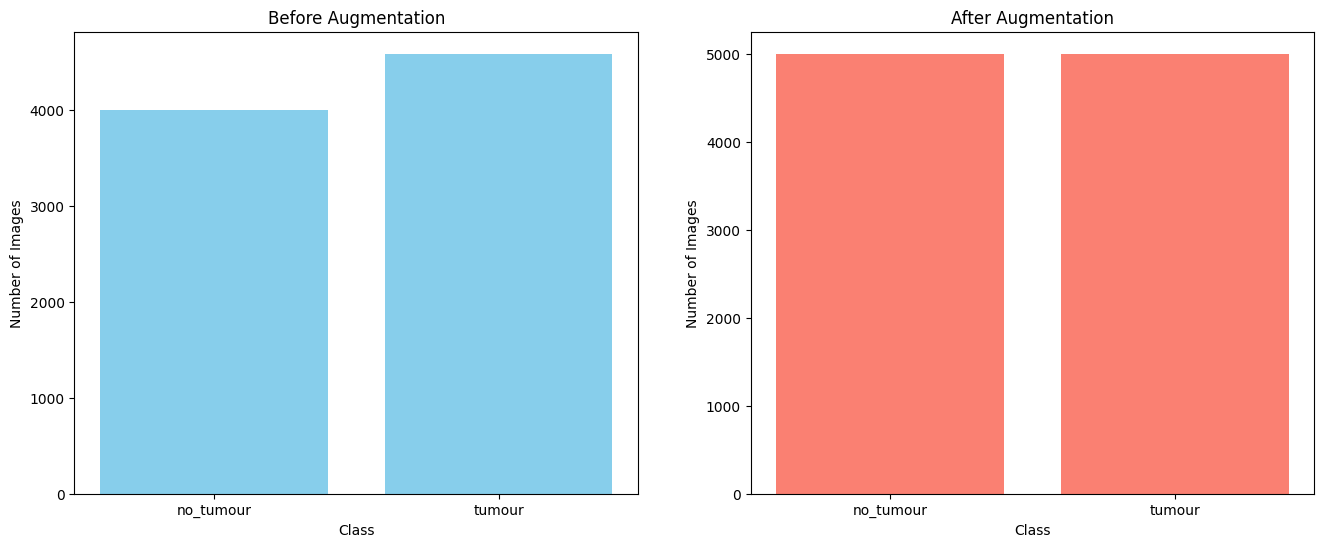

In [29]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

import matplotlib.pyplot as plt

before_counts = {cls: count_images(os.path.join(RAW_DATASET_PATH, cls)) for cls in tumor_classes}
after_counts = {cls: count_images(os.path.join(OUTPUT_SPLIT_DIR, "Train", "Images", cls)) for cls in tumor_classes}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].bar(before_counts.keys(), before_counts.values(), color="skyblue")
axes[0].set_title("Before Augmentation")
axes[0].set_ylabel("Number of Images")
axes[0].set_xlabel("Class")

axes[1].bar(after_counts.keys(), after_counts.values(), color="salmon")
axes[1].set_title("After Augmentation")
axes[1].set_ylabel("Number of Images")
axes[1].set_xlabel("Class")
plt.show()

Visualizing a Tumor Region

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


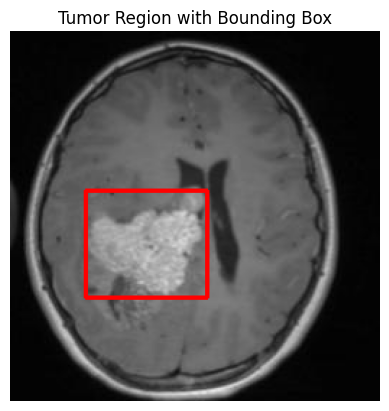

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


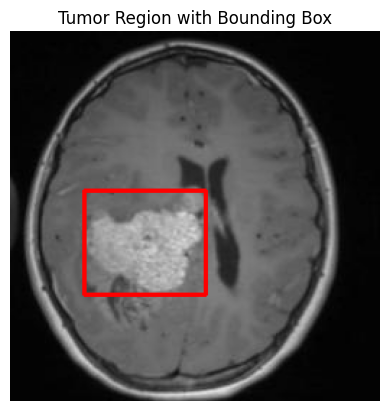

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


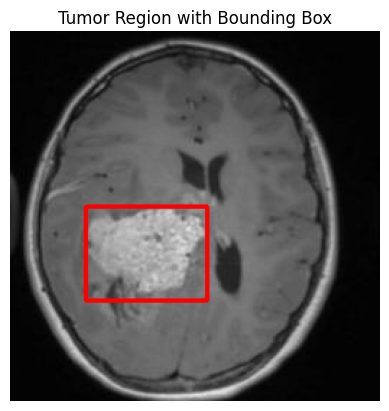

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


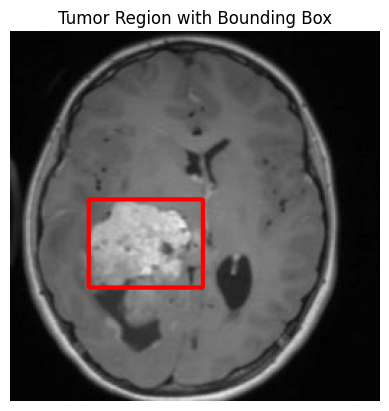

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


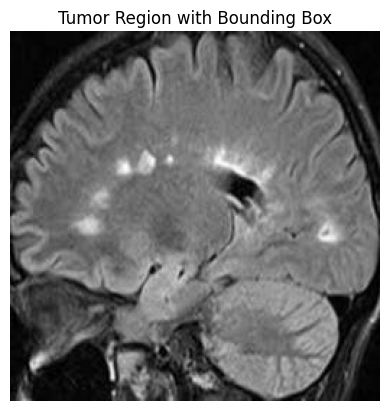

In [30]:
def visualize_tumor_with_bbox(image_path, unet_model):
    """Visualize an image with its tumor region bounding box."""
    # Preprocess image
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return  # Or raise an exception

    image = preprocess_image(image_path)
    img_resized = tf.image.resize(image, TARGET_SIZE)
    img_batch = tf.expand_dims(img_resized, axis=0)
    # Generate mask using U-Net
    mask = unet_model.predict(img_batch)[0]
    # Convert mask to bounding box
    bbox = generate_bbox_from_mask(mask, threshold=0.5)
    # Prepare image for display
    disp_img = (image * 255).astype(np.uint8)
    disp_img = cv2.resize(disp_img, TARGET_SIZE)
    if bbox is not None:
        cv2.rectangle(disp_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
    plt.imshow(disp_img)
    plt.title("Tumor Region with Bounding Box")
    plt.axis("off")
    plt.show()

# Example: Visualize an image from the 'tumour' class
# Make sure 'example_image' points to a valid image file
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/z.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/x.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/v.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/yw54y.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/no_tumour/Tr-noTr_0009.jpg"
visualize_tumor_with_bbox(example_image, unet_model)